# Bring in libraries and dataframes and set indexes

In [53]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
#Read in data
AllData=pd.read_csv('.\RawDatafiles\AllCS650rawdata.csv.gz', #specify file path for data to read in
                    compression='gzip', #tell the function it is a compressed file
                    parse_dates=True, #tell the function to parse date columns to datetime formats
                    dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                    index_col = 0, #Use the first column, which is Date, as an index
                    na_values = 'NAN')

#Bring in index data
AllDataIndex=pd.read_csv('.\IndexFiles\CS616index.csv',
                         index_col = 0)
AllDataIndex.Block = [str(x) for x in AllDataIndex.Block]
#Apply indexes to data
AllDataTransposed = AllData.transpose()
AllDataIndexed = pd.concat([AllDataIndex,AllDataTransposed], axis=1)
AllDataIndexed.index.name='ColumnHeader'
AllDataIndexed.set_index(['Depth','Species','Irrigation','Block'], 
                        append=False, inplace=True)
AllDataIndexed.sort_index(inplace=True)
AllDataIndexed.sort_index(inplace=True,axis=1)
Data=AllDataIndexed.transpose()
Data.index = pd.to_datetime(Data.index)  ## for some reason the concat function changes the data type on the date indes so need to change it back

# Take a look at all of the data

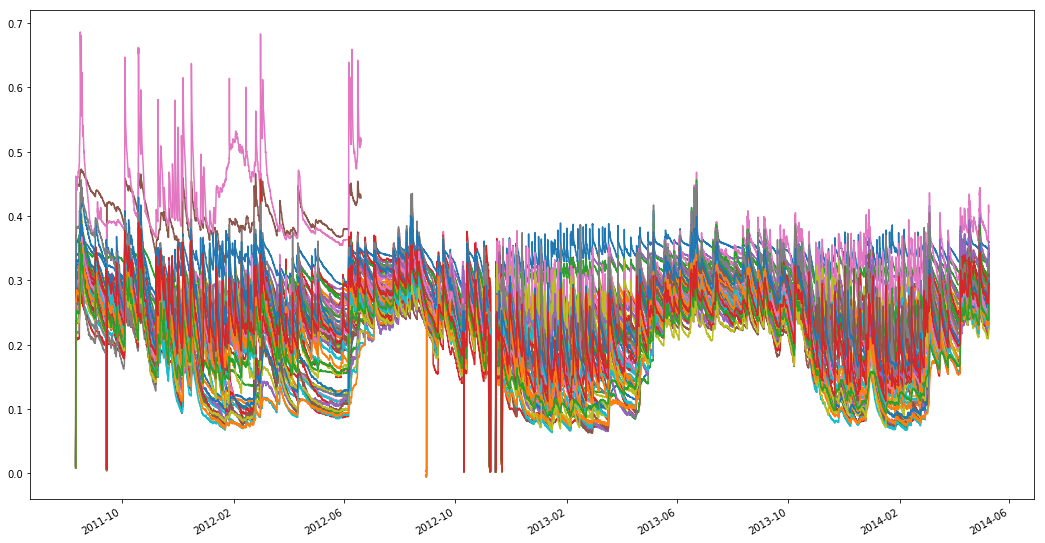

In [55]:
Data.plot(figsize=(18,10),legend=False)

### There were a couple of sensors that were giving high values before June 2012 and some periods where some or all sensors were giving close to zero measurements.  The data points need to be set to nul

# Remove erronius values

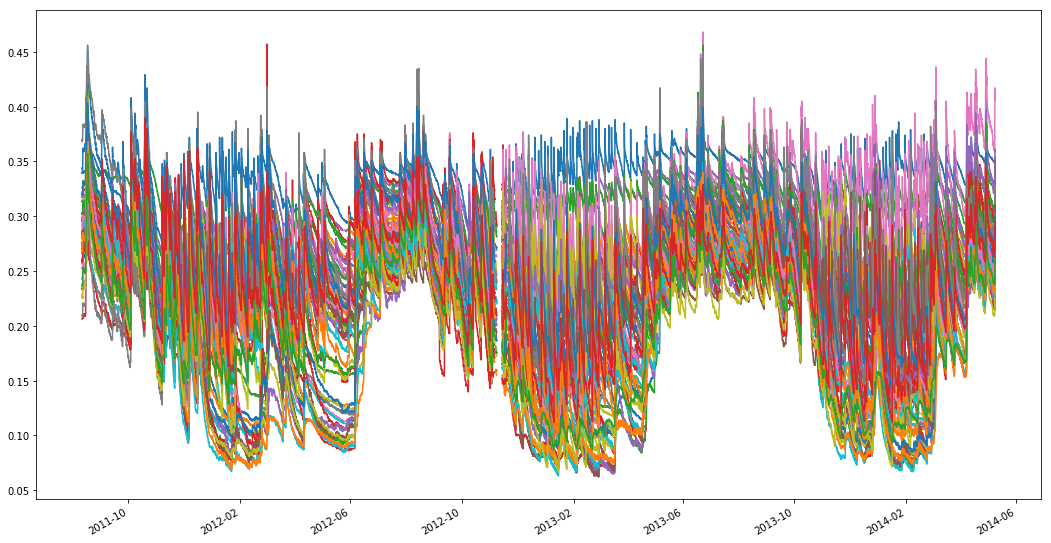

In [56]:
#Set low values where sensors where not working to nan
Data.where(Data>0.04, np.nan,inplace=True)
#Remove data from plot 15 when high readings
Data.loc[:'2012-06-19 13:00:00',('D23','Lucerne','High','2')] = np.nan 
#Remove data from plot 19 when high readings
Data.loc[:'2012-06-19 13:00:00',('D23','Lucerne','High','3')] = np.nan 

#Graph dataframe to check all is good
Data.plot(figsize=(18,10),legend=False)

# Synthesise data to plug gaps

Now we have a data frame containing only legitimate data and nan values.  Next we need to replace the nan values with synthetic data.  To do this we will replace nan values with the mean for that treatment plus a plot specific offset.  This can only be done where some of the sensors in the same treatment were working and others weren't.  Where all sensors failed we are stuck with no data 

## First we calculate treatment means

In [57]:
AllTreatmentMeans= Data.groupby(level=['Depth','Species','Irrigation'],axis=1).mean()
AllTreatmentMeans.plot(figsize=(18,10), legend = False)

### Then we calcualte the offset for each sensor relative to their treatment mean

In [58]:
#Set up empty dataframe with the same index and column structure as TDR data
OffSets = pd.DataFrame(index = Data.index, columns = Data.columns)  
#Step through each plot, calculate offset at each measurement date relative to the treatment mean at that date
#and load the number into the OffSet dataframe
for X in range (0,64): 
    Depth = AllDataIndex.iloc[X,0]
    Crop = AllDataIndex.iloc[X,1]
    Irrigation = AllDataIndex.iloc[X,2]
    Block = AllDataIndex.iloc[X,3]
    #Set a series of values representing the mean VWC at each measurement date for the respecitive treatment
    TreatmentMeans = AllTreatmentMeans.loc[:,(Depth, Crop, Irrigation)] 
    #Set a series of values representing the VWC at each measurement date for the specified plot
    SeriesValues = Data.loc[:,(Depth, Crop, Irrigation, Block)]  
    #Set offset values for specified plot in dataframe
    OffSets.loc[:,(Depth, Crop, Irrigation, Block)]  = SeriesValues - TreatmentMeans

### Then graph offsets against VWC for the treatment mean to see if there is any systematic variation in offsets

In [59]:
Fig = plt.figure(figsize=(18, 60))

def MakePlot(Position, TreatVWC, SeriesOffSet, Series):
    Fig.add_subplot(16,4,Position)
    plt.title(Series, fontsize=12);
    plt.plot(TreatVWC,SeriesOffSet, 'o');
    return;
    
for X in range (0,64):
    Position = X+1;
    Depth = AllDataIndex.iloc[X,0]
    Crop = AllDataIndex.iloc[X,1]
    Irrigation = AllDataIndex.iloc[X,2]
    Block = AllDataIndex.iloc[X,3]
    Series = Depth+Crop+Irrigation+Block
    #Set a series of values representing the mean VWC at each measurement date for the respecitive treatment
    TreatmentMeans = AllTreatmentMeans.loc[:,(Depth, Crop, Irrigation)] 
    #Set a series of values representing the amount that VWC is offset from the treatment mean at each 
    #measurement date for the specified plot
    SeriesOffSets = OffSets.loc[:,(Depth, Crop, Irrigation, Block)] 
    #Draw graphs
    MakePlot(Position, TreatmentMeans, SeriesOffSets, Series)

### Pattern of Offsets appears random so can just use mean offset to create synthetic data

### So now we create synthetic data

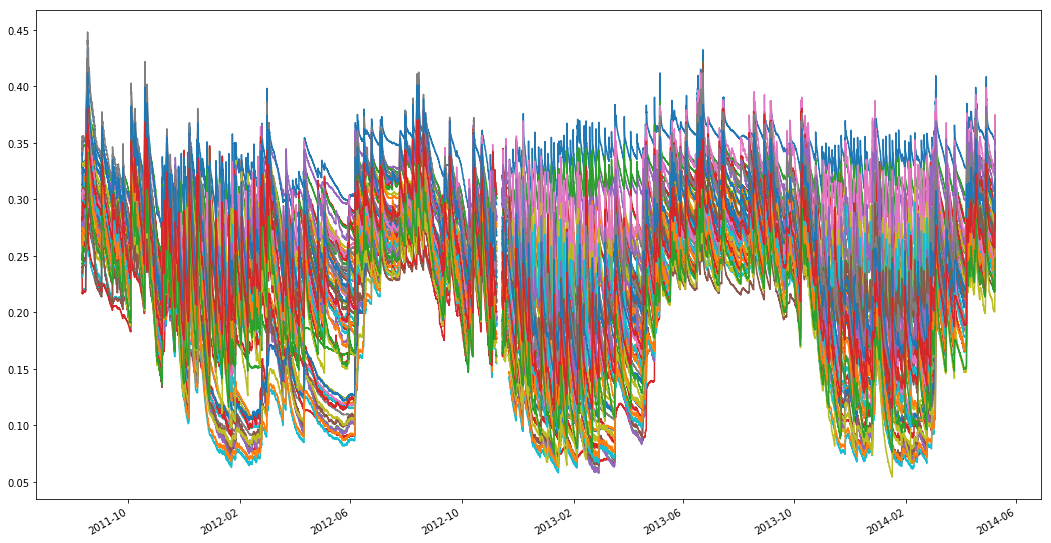

In [60]:
#Set up empty dataframe with the same index and column structure as TDR data
SynthData = pd.DataFrame(index = Data.index, columns = Data.columns)  
#Step through each plot, calculate offset and load the number into the OffSet dataframe
for X in range (0,64): 
    Depth = AllDataIndex.iloc[X,0]
    Crop = AllDataIndex.iloc[X,1]
    Irrigation = AllDataIndex.iloc[X,2]
    Block = AllDataIndex.iloc[X,3]
    #Set a series of values representing the mean VWC at each measurement date for the respecitive treatment
    TreatmentMeans = AllTreatmentMeans.loc[:,(Depth, Crop, Irrigation)] 
    #Set a series of values representing the amount that VWC is offset from the treatment mean at 
    #each measurement date for the specified plot
    SeriesOffSets = OffSets.loc[:,(Depth, Crop, Irrigation, Block)]  
    SynthData.loc[:,(Depth, Crop, Irrigation, Block)] = TreatmentMeans + SeriesOffSets.mean()  

#Plot synthetic Data to make sure it looks OK
SynthData.plot(figsize=(18,10), legend = False)


## Now replace nan values in Data dataframe with synthetic data

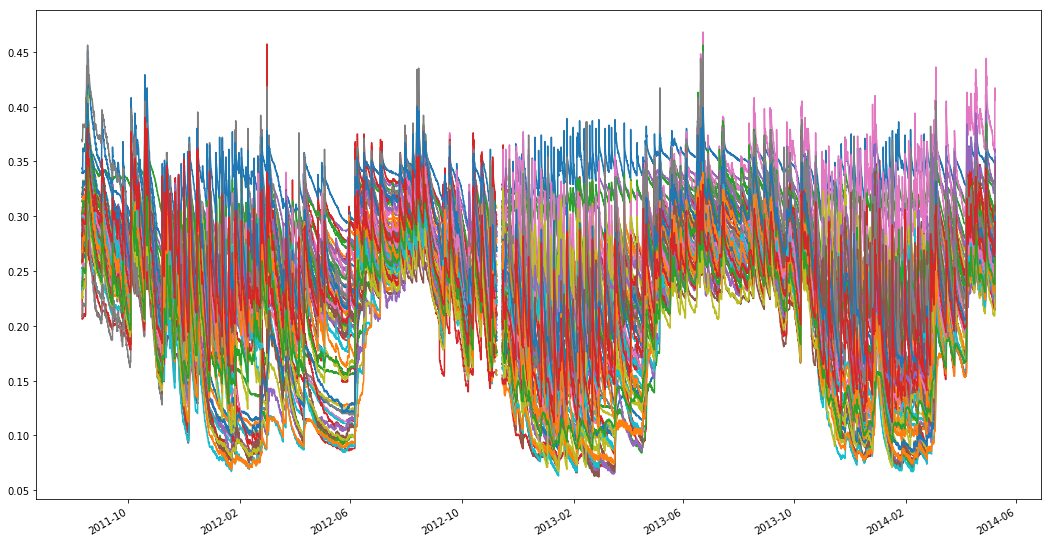

In [61]:
Data.fillna(SynthData, inplace = True)
Data.plot(figsize=(18,10), legend = False)

# Export hourly dataframe and publish note book as gist

In [62]:
#Export hourly datafile as pickle
Data.loc[Data.index.hour==9,:].to_pickle('.\DataFrames\LandPDailyTDR.pkl')